In [183]:
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scripts.parsing_utils import *
from utils.utils import *
from scripts.parse_results import *
import torch
from utils.net import *
import klepto

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
#RES_DIR = "./debug/nested_loop_index7-mscn-df:10-nn:1:128-loss:mse-0.0--D0.1-831/"
RES_DIR = "/home/pari/learned-cardinalities/all_results/inl_fixed_scan_ops/nested_loop_index7/test_diff/subq_imp2/diff_partitions-nested_loop_index7-mscn-df:10-nn:1:256-loss:mse-0.0--D0.1-926/"
RES_DIR = "/home/pari/learned-cardinalities/all_results/inl_fixed_scan_ops/"
#RES_DIR = "./debug/"
WEIGHT_FN = "model_weights.pt"

In [216]:
def viz_weight_means(weights, kind):
    flow_weights = weights[kind].cpu().numpy()
    #flow_weights = np.maximum(flow_weights, 0.0)
    flow_weights = np.mean(flow_weights, axis=0)
    sns.barplot(y=flow_weights)
    plt.title(kind)
    plt.show()

In [189]:
args = load_object(RES_DIR + "/args.pkl")
print(args)
weights = torch.load(RES_DIR + WEIGHT_FN)

Namespace(adaptive_lr=0, adaptive_lr_patience=20, algs='nn', avg_factor=1, avg_jl_num_last=5, avg_jl_priority=1, baseline_join_alg='EXHAUSTIVE', cache_dir='./caches/', cl_recompute=0, clip_gradient=20.0, compute_runtime=0, cost_model='nested_loop_index7', cost_model_plan_err=1, data_dir='/data/pari/cards/', db_file_name=None, db_host='localhost', db_name='imdb', debug_set=0, diff_templates_seed=2, diff_templates_type=3, dropout=0.0, eval_epoch=10, eval_epoch_flow_err=1, eval_epoch_jerr=1, eval_epoch_plan_err=1, eval_flow_loss=1, eval_num_tables=0, eval_on_job=1, eval_parallel=0, eval_test_while_training=1, execution_cache_threshold=20, exp_name='card_exp', exp_prefix='diff_partitions', feat_pg_costs=1, feat_pg_est_one_hot=0, feat_pg_path=1, feat_rel_pg_ests=1, feat_rel_pg_ests_onehot=0, feat_tolerance=1, flow_features=0, gen_bn_dist=0, gen_synth_data=0, group_models=0, heuristic_features=1, hidden_layer_multiple=None, hidden_layer_size=256, jl_indexes=1, jl_use_postgres=1, jl_variant=0

In [190]:
type(weights)

collections.OrderedDict

In [191]:
weights.keys()
# TODO: remove negative values in analysis as ReLU will remove them too

odict_keys(['sample_mlp1.0.weight', 'sample_mlp1.0.bias', 'sample_mlp2.0.weight', 'sample_mlp2.0.bias', 'predicate_mlp1.0.weight', 'predicate_mlp1.0.bias', 'predicate_mlp2.0.weight', 'predicate_mlp2.0.bias', 'join_mlp1.0.weight', 'join_mlp1.0.bias', 'join_mlp2.0.weight', 'join_mlp2.0.bias', 'out_mlp1.0.weight', 'out_mlp1.0.bias', 'out_mlp2.0.weight', 'out_mlp2.0.bias'])

In [192]:
print(weights["predicate_mlp1.0.weight"].shape[1])

836


In [193]:
args.hidden_layer_size

256

In [197]:
if args.flow_features:
    net = SetConv(weights["sample_mlp1.0.weight"].shape[1], weights["predicate_mlp1.0.weight"].shape[1], 
             weights["join_mlp1.0.weight"].shape[1], weights["flow_mlp1.0.weight"].shape[1], args.hidden_layer_size)
else:
    net = SetConv(weights["sample_mlp1.0.weight"].shape[1], weights["predicate_mlp1.0.weight"].shape[1], 
        weights["join_mlp1.0.weight"].shape[1], 0, args.hidden_layer_size)

In [198]:
net

SetConv(
  (sample_mlp1): Sequential(
    (0): Linear(in_features=21, out_features=256, bias=True)
    (1): ReLU()
  )
  (sample_mlp2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
  )
  (predicate_mlp1): Sequential(
    (0): Linear(in_features=836, out_features=256, bias=True)
    (1): ReLU()
  )
  (predicate_mlp2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
  )
  (join_mlp1): Sequential(
    (0): Linear(in_features=129, out_features=256, bias=True)
    (1): ReLU()
  )
  (join_mlp2): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
  )
  (out_mlp1): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): ReLU()
  )
  (out_mlp2): Sequential(
    (0): Linear(in_features=256, out_features=1, bias=True)
    (1): Sigmoid()
  )
  (drop_layer): Dropout(p=0.0, inplace=False)
)

In [199]:
misc_cache = klepto.archives.dir_archive("./misc_cache",
            cached=True, serialized=True)
db_key = deterministic_hash("db-" + args.query_directory + \
                args.query_templates + str(args.eval_on_job))
assert db_key in misc_cache.archive
db = misc_cache.archive[db_key]
db.init_featurizer(num_tables_feature = args.num_tables_feature,
            max_discrete_featurizing_buckets =
            args.max_discrete_featurizing_buckets,
            heuristic_features = args.heuristic_features,
            flow_features = args.flow_features,
            feat_pg_costs = args.feat_pg_costs,
            feat_pg_path = args.feat_pg_path,
            feat_rel_pg_ests = args.feat_rel_pg_ests,
            feat_rel_pg_ests_onehot = args.feat_rel_pg_ests_onehot,
            feat_pg_est_one_hot = args.feat_pg_est_one_hot,
            feat_tolerance = args.feat_tolerance,
            cost_model = args.cost_model)


In [200]:
pred_maps = db.get_pred_features_map()

[833, 834, 835]


In [201]:
print(max(pred_maps["idx"]))
pred_weights = weights["predicate_mlp1.0.weight"].cpu().numpy()
print(pred_weights.shape)

835
(256, 836)


In [202]:
pred_maps.head(10)

,idx,descr,continuous,pg,feature_type
0,0,t.production_year-lt,True,False,pred
1,1,t.production_year-like,True,False,pred
2,2,t.production_year-nlike,True,False,pred
3,3,t.production_year-in,True,False,pred
4,4,t.production_year-eq,True,False,pred
5,7,t.production_year-pg,True,True,pred
6,5,t.production_year-range,True,False,pred
7,6,t.production_year-range,True,False,pred
8,8,t.title-lt,False,False,pred
9,9,t.title-like,False,False,pred


In [208]:
pred_weights = weights["predicate_mlp1.0.weight"].cpu().numpy()
#pred_weights = np.maximum(pred_weights, 0.0)
mean_weights = np.mean(pred_weights, axis=0)

In [219]:
# FIXME: this should map exactly?
pred_maps["weight"] = pred_maps.apply(lambda row: mean_weights[row["idx"]], axis=1)

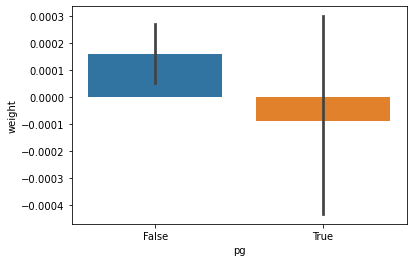

In [221]:
sns.barplot(x="pg", y="weight", data=pred_maps)
plt.show()

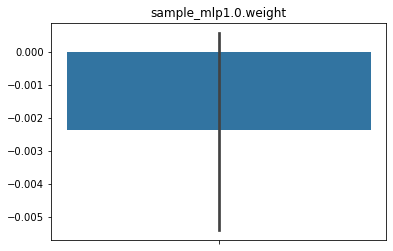

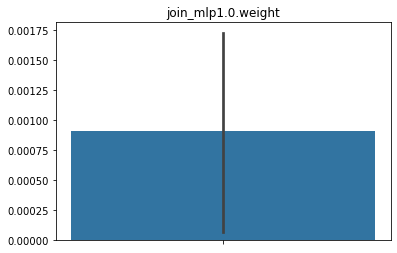

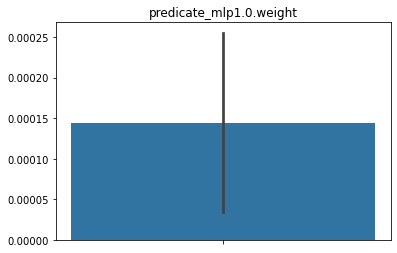

In [222]:
if args.flow_features:
    viz_weight_means(weights, kind="flow_mlp1.0.weight")
viz_weight_means(weights, kind="sample_mlp1.0.weight")
viz_weight_means(weights, kind="join_mlp1.0.weight")
viz_weight_means(weights, kind="predicate_mlp1.0.weight")

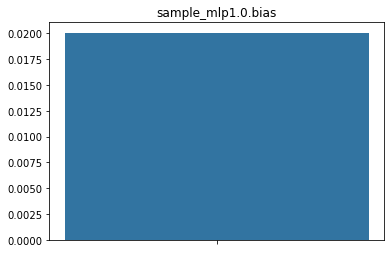

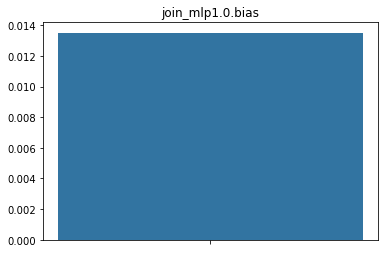

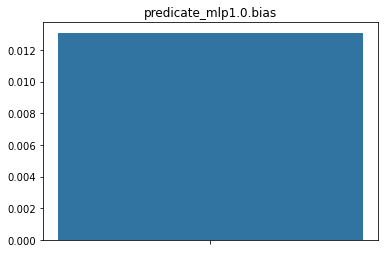

In [223]:
if args.flow_features:
    viz_weight_means(weights, kind="flow_mlp1.0.bias")
viz_weight_means(weights, kind="sample_mlp1.0.bias")
viz_weight_means(weights, kind="join_mlp1.0.bias")
viz_weight_means(weights, kind="predicate_mlp1.0.bias")

In [224]:
print(args.flow_features)

0
